# WATER BAG PREDICTION - Model Selection

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [2]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time serie features transformation pipeline & binary classification pipeline (Authoral)
from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample, groupSplitGridSearch
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt

#### Imbalanced preprocessing & learning modules
from scipy.stats import loguniform
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

#### Preprocessing & machine learning modules
from sklearn.utils import all_estimators
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

#### Metrics and scoring functions
from sklearn.metrics import (
    make_scorer, recall_score, precision_score,
    f1_score, precision_recall_fscore_support,
    classification_report as cr
)

recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)
f1_0 = make_scorer(f1_score, pos_label=0)
f1_1 = make_scorer(f1_score, pos_label=1)

scoring = {
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1,
    'f1-0': f1_0, 'f1-1': f1_1
}

c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Custom functions

In [3]:
def split_report(Y, yt, ye):
    cnts = [yt.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
    print('\nTrain folder'); display(pd.concat(cnts, 1))
    cnts = [ye.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
    print('\nValidation folder'); display(pd.concat(cnts, 1))

    eval_size = len(ye) / len(Y) * 100
    eval_minority = (ye==1).sum() / (Y==1).sum() * 100
    train_minority = (ye==0).sum() / (Y==0).sum() * 100
    eval_stats = pd.DataFrame(
        [eval_size, train_minority, eval_minority],
        ['Samples left', 'Negative Samples left', 'Positive Samples left'],
        ['Validation (%)'],
    ).round(2)
    display(eval_stats)

from sklearn.metrics import precision_recall_curve

def precision_recall_plot(ye, yprob, threshold=None):
    
    curve = pd.DataFrame(
        precision_recall_curve(ye, yprob, pos_label=1),
        index=['precision', 'recall', 'threshold']
    ).T.set_index('threshold').add_suffix(f' - 1')
    curve['f1 - 1'] = curve.mean(1)
    prec, rec = curve['precision - 1'], curve['recall - 1']
    curve['harmonic mean - 1'] = 2 * prec * rec / (prec + rec)
#     display(harmonic_mean.sort_values(ascending=False).head(harmonic).to_frame('Harmonic mean'))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 3.5))
    curve.plot(ax=ax[0]); curve.reset_index().plot('recall - 1', ['precision - 1', 'threshold', 'f1 - 1', 'harmonic mean - 1'], ax=ax[1])
    ax[1].set(title='Precision Recall Curve')

        
    if threshold is not None:
        yhat_fix = (yprob > threshold).astype('int')
        scr = pd.DataFrame(cr(ye, yhat_fix, digits=4, output_dict=True)).T
        return ax, scr
    return ax

def classifier_evaluation(model, xe, ye, threshold=None, flat_score=False):
    try: yprob = pd.Series(model.predict_proba(xe)[:, 1], index=xe.index)
    except:
        try: yprob = pd.Series(model.decision_function(xe), index=xe.index)
        except: yprob = pd.Series(model.predict(xe), index=xe.index)
    ax = precision_recall_plot(ye, yprob, threshold=None); plt.show()
    if threshold is None:
        threshold = float(input('Select decision threshold:'))
    yhat = (yprob >= threshold).astype('int')
    scr = pd.DataFrame(
        precision_recall_fscore_support(ye, yhat),
        index=['precision', 'recall', 'f1', 'support']
    ).T; display(scr)
    if flat_score:
        scr = pd.concat([scr.loc[label].add_suffix('-' + str(label)) for label in [0, 1]], 0)
    return scr, threshold

#### Grid search classification score visualization function

def classifier_scr_grid_plot(scr_grid, figsize=(14, 4), share_y=True, param_name='param_gbc__n_estimators', ax_params={}):
    fig, ax = plt.subplots(1, 2, True, share_y, figsize=figsize)
    train_cols = ['mean_train_precision-1', 'mean_train_recall-1', 'mean_train_f1-1']
    test_cols = ['mean_test_precision-1', 'mean_test_recall-1', 'mean_test_f1-1']
    scr_grid.set_index(param_name)[train_cols].plot(ax=ax[0])
    scr_grid.set_index(param_name)[test_cols].plot(ax=ax[1])
    for axe in ax: axe.set(**ax_params)
    plt.show()

#### Save model + metadata function

In [4]:
def save_model(model_info, path):
    model_path = path + model_info['name'] + '-' + model_info['id'] + '/'
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model_file = model_path + 'model_' + model_info['id'] + '.pickle'
    pickle.dump(final_model, open(model_file, 'wb'))
    
    str_info = []
    for key in model_info.keys():
        if type(model_info[key]) is str: str_info.append(key)
        elif type(model_info[key]) is pd.DataFrame:
            score_file = model_path + key + '_' + model_info['id'] + '.csv'
            model_info[key].to_csv(score_file, index=True)
            
    with open(model_path + 'metadata.json', 'w') as file:
        file.write(json.dumps({key: model_info[key] for key in str_info}))

#### Select and split target from dataset

In [5]:
def select_target(target_id, periods_ahead=4, report=True):

    print(f'Selected target: {target_names[int(target_id)]} - id: {target_id}', '\n')

    # Select target
    Y = Yi[str(target_id)].loc[X.index].copy()
    if report: display(Y.value_counts().to_frame('Target'))

    ### Target transformation
    if periods_ahead is not None:
        Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(-periods_ahead + 1) > 0).astype('float')
        if report: display(Y.value_counts().to_frame('Transformed Target'))

    # Group target positive class labels by being consecutive in time (group evaluation strategy)
    groups = groupConsecutiveFlags(ts=Y)

    # Target validation split
    yt = Y.loc[xt.index]
    ye = Y.loc[xe.index]
    groups_train = groups.loc[xt.index]
    groups_eval = groups.loc[xe.index]

    ### Validation statistics
    if report: split_report(Y, yt, ye)
        
    return Y, yt, ye, groups, groups_train, groups_eval

#### Cross validate undersample pipeline

In [6]:
def undersample_cross_validation(model, train_prct):
    # undersample pipeline
    if train_prct=='natural': train_prct = yt.mean() / (1 - yt.mean())
    steps = [
        ('under', RandomUnderSampler(sampling_strategy=train_prct, random_state=0)),
        ('model', model)
    ]; pipe = Pipeline(steps=steps)
    # cross-validation split
    cv_group = splitter.split(xt, yt, groups_train, strategy)
    # evaluate splits
    return pd.DataFrame(cross_validate(
        pipe, xt, yt, groups=groups_train,
        scoring=scoring, cv=cv_group,
        n_jobs=-1, verbose=5,
        pre_dispatch='2*n_jobs',
        return_train_score=True,
    ))

---
## Load & Preprocess Data

In [7]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True)

data = project.data
Yi = project.time_serie.drop('-1', 1)
waterbags = project.waterbags

# Sample groups names per group label
target_names = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

# Project and model deployment paths
path_project = 'API Deploy/'
path_models = 'API Deploy/Modelos/'

---
# Feature and target selection

### Feature set

In [8]:
train_start, train_end = '2018-06', '2021-10'
eval_start, eval_end = '2021-11', '2022-04'

transform_args = dict(
    scale=True, interpolate='nearest', fillna='min'
)

# Select feature set
X = TimeseriesTransformPipeline(
    data, train_start, cut=-1,
    drop_empty_cols=True,
    **transform_args,
); X = X[: eval_end]

# Validation split
xt = X[:train_end]
xe = X[eval_start: eval_end]

Initial data: (437875, 230)
Time extraction: (142866, 230)
Drop empty columns:  (142865, 217)


### Save feature set deployment information

In [9]:
# Select raw feature set for preprocessing
X_raw = TimeseriesTransformPipeline( # Must use untransformed data to perform filtering fiter
    data, train_start, cut=-1,
    drop_empty_cols=True, scale=False,
    interpolate=None, fillna=None
); X_raw = X_raw[: eval_end]

# Save Features description
if path_project is not None:
    X_info = X_raw.describe().loc[['min', 'max', 'mean']].T
#     X_info.to_csv(path_project + 'deploy_info.csv', index=True)

Initial data: (437875, 230)
Time extraction: (142866, 230)
Drop empty columns:  (142865, 217)


### Pipeline & target loop parameters

In [30]:
seed = 0
periods_ahead = 4

LinearSVC = classifiers['LinearSVC']
model = LinearSVC(C=1.0, random_state=seed)

splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    train_size=0.79, test_size=0.20, # Not used if minority split strategy is GroupKFold
    train_prct=None, test_prct='natural',
    random_state=seed
); strategy='GroupKFold'

---
# Class proportion tunning - Multi-target cross validation grid search

In [31]:
scr_cols = ['train_recall-1', 'train_precision-1', 'train_f1-1', 'test_recall-1', 'test_precision-1', 'test_f1-1']

### Class proportion optimization pipeline

#### Steps:
1. Tunning with cross validation on train data
2. Test optimal parameter on validation data
3. Tunning with cross validation on train + validation data (final model parameters)

Obs: It will be assumed that parameters found by tunning on train + validation data will work for novel data, as the ones found by tunning on train data worked for the validation data.

In [58]:
target_id = '1'

# def undersample_grid_search(model, train_prct):

Y, yt, ye, groups, groups_train, groups_eval = select_target(target_id, periods_ahead, report=False)

# cross-validation split
cv_group = splitter.split(xt, yt, groups_train, strategy)

# undersample pipeline
    
steps = [
    ('under', RandomUnderSampler(sampling_strategy=None, random_state=0)),
    ('model', model)
]; pipe = Pipeline(steps=steps)

Selected target: Rua do Catete - id: 1 



In [59]:
train_prct = 'natural'
n_params = 10
param_range =  np.arange(.005, 0.2, 0.005)

if train_prct=='natural': train_prct = yt.mean() / (1 - yt.mean())
params = param_range[param_range > train_prct][: n_params]
# params = np.arange(.015, .05, 0.005)

# evaluate splits
param_grid = {
#         'under__sampling_strategy': loguniform(1 / major_prct, max_prct).ppf(np.linspace(0, 1, n_prcts)),
    'under__sampling_strategy': params,
}; print('\n', 'Parameter Grid:', '\n'); print(param_grid)


 Parameter Grid: 

{'under__sampling_strategy': array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055])}


Fitting 5 folds for each of 10 candidates, totalling 50 fits

 Cross validation grid search (Train data): 



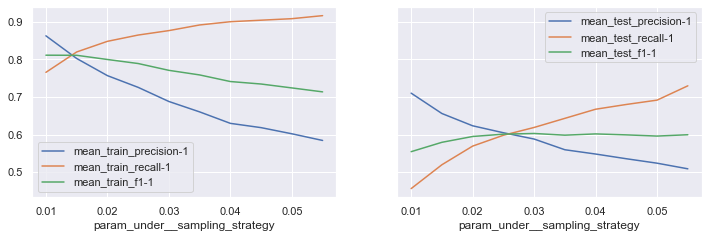

In [60]:
### Evaluate pipeline
grid_search = GridSearchCV(
    pipe, param_grid, scoring=scoring, cv=cv_group,
    n_jobs=-1, verbose=2, error_score='raise',
    return_train_score=True, refit=False
)
grid_search = grid_search.fit(xt, yt)
scr_grid = pd.DataFrame(grid_search.cv_results_)

print('\n', 'Cross validation grid search (Train data):', '\n')
classifier_scr_grid_plot(scr_grid, figsize=(12, 3.5), param_name='param_under__sampling_strategy')

Selected sampling strategy: 0.026


c:\Users\luisr\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


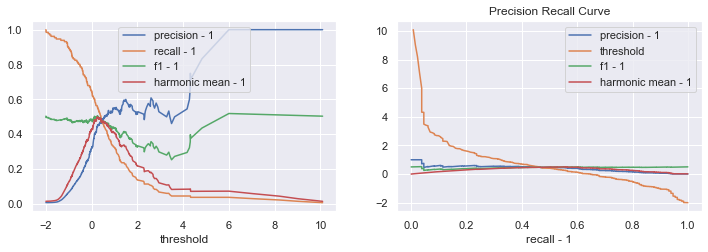

Select decision threshold: .5


,precision,recall,f1,support
0,0.995885,0.996289,0.996087,17245.0
1,0.483871,0.458015,0.470588,131.0


(   precision    recall        f1  support
 0   0.995885  0.996289  0.996087  17245.0
 1   0.483871  0.458015  0.470588    131.0,
 0.5)

In [62]:
pipe.steps[0][1].sampling_strategy = float(input('Selected sampling strategy:'))

pipe.fit(xt, yt)

classifier_evaluation(pipe, xe, ye)

### Multiple target variable loop

Modeling target Rua Haddock Lobo - id: 14 



,Target
0.0,137128
1.0,151


,Transformed Target
0.0,137065
1.0,214



Train folder


,Class Count,Class Count
0.0,119743,0.998666
1.0,160,0.001334



Validation folder


,Class Count,Class Count
0.0,17322,0.996892
1.0,54,0.003108


,Validation (%)
Samples left,12.66
Negative Samples left,12.64
Positive Samples left,25.23


,Train set,Test set
Class,,
0.0,90555,29187
1.0,121,39



 Parameter Grid: 

{'under__sampling_strategy': array([0.0013362 , 0.00197809, 0.00292834, 0.00433507, 0.00641759,
       0.00950052, 0.01406445, 0.02082083, 0.03082291, 0.04562985,
       0.06754987, 0.1       ])}
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Cross validation grid search (Train data): 



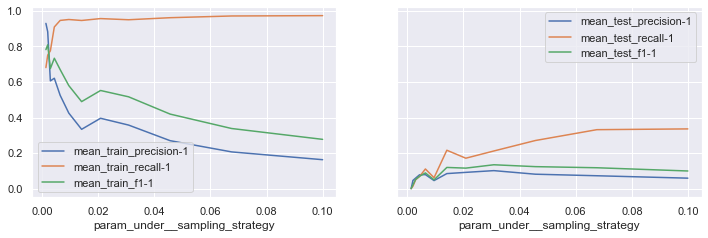


Optimal minority class proportion: 0.01


,Class Count
0.0,16000
1.0,160



 Evaluation on validation data: 

      Iter       Train Loss   Remaining Time 
         1           0.0551            8.00s
         2           0.0514            7.34s
         3           0.0484            8.21s
         4           0.0452            7.73s
         5           0.0427            7.68s
         6           0.0413            7.24s
         7           0.0401            6.64s
         8           0.0384            6.25s
         9           0.0334            5.83s
        10           0.0312            5.38s
        20           0.0197            1.75s


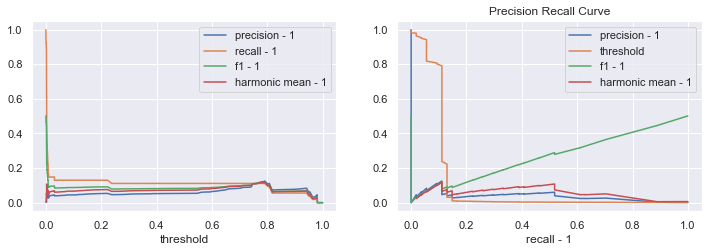

Select decision threshold: .5


,precision,recall,f1,support
0,0.997220,0.993938,0.995576,17322.0
1,0.054054,0.111111,0.072727,54.0


,Train set,Test set
Class,,
0.0,97354,34586
1.0,152,54



 Parameter Grid: 

{'under__sampling_strategy': array([0.0015613 , 0.00227885, 0.00332617, 0.00485481, 0.007086  ,
       0.01034259, 0.01509586, 0.02203364, 0.0321599 , 0.04694   ,
       0.06851278, 0.1       ])}
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Cross validation grid search (Final model): 



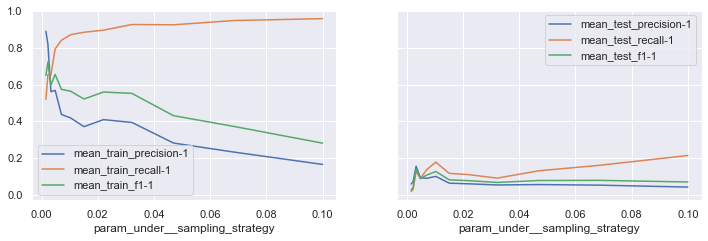


Optimal minority class proportion: 0.01


,Class Count - Final model
0.0,21400
1.0,214



 Fit final model: 

      Iter       Train Loss   Remaining Time 
         1           0.0637           10.66s
         2           0.0581            9.54s
         3           0.0556            9.07s
         4           0.0532            8.58s
         5           0.0504            8.10s
         6           0.0484            7.64s
         7           0.0472            7.19s
         8           0.0456            6.95s
         9           0.0425            6.55s
        10           0.0405            6.11s
        20           0.0288            1.99s






Exit? y


In [12]:
target_results = []
for i, target_id in enumerate(Yi.columns[first_target:]):

    Y, yt, ye, groups, groups_train, groups_eval = select_target(target_id, periods_ahead, report=False)
    
    ### Group split on train data - Grouped by target consecutive positive observations

    # Train data group shuffle split
    cv_group = splitter.split(xt, yt, groups_train, strategy=strategy)

    ### Cross validation & grid search parameters

    steps = [('under', RandomUnderSampler(random_state=0)), ('model', model)]
    pipe = Pipeline(steps=steps)

    major_prct = (1 - yt.mean()) / yt.mean()
    param_grid = {
        'under__sampling_strategy': loguniform(1 / major_prct, max_prct).ppf(np.linspace(0, 1, n_prcts)),
    }; print('\n', 'Parameter Grid:', '\n'); print(param_grid)

    ### Evaluate pipeline
    grid_search = GridSearchCV(
        pipe, param_grid, scoring=scoring, cv=cv_group,
        n_jobs=-1, verbose=2, error_score='raise',
        return_train_score=True, refit=False
    )
    grid_search = grid_search.fit(xt, yt)
    scr_grid = pd.DataFrame(grid_search.cv_results_)
    
    print('\n', 'Cross validation grid search (Train data):', '\n')
    classifier_scr_grid_plot(scr_grid, figsize=(12, 3.5), param_name='param_under__sampling_strategy')

    ### Optimal parameters on validation data

    minor_prct = float(input('\nOptimal minority class proportion:'))
    rus = RandomUnderSampler(sampling_strategy=minor_prct, random_state=0)
    x_res, y_res = rus.fit_resample(xt, yt)

    display(y_res.value_counts().to_frame('Class Count'))
    print('\n', 'Evaluation on validation data:', '\n')
    score_eval, thresh_eval = classifier_evaluation(model, x_res, y_res, xe, ye)

    ### Group split on train + validation data (final model) - Grouped by target consecutive positive observations

    # Train + validation data group shuffle split - Final model
    cv_group_final = list(splitter.split(
        X, Y, groups,
        strategy=strategy
    )); print_cls_cnt(Y, cv_group_final[0][0], cv_group_final[0][1])

    ### Cross validation & grid search parameters - Final model

    steps = [('under', RandomUnderSampler(random_state=0)), ('model', model)]
    pipe = Pipeline(steps=steps)

    minor_prct = Y.mean() / (1 - Y.mean())
    param_grid = {
        'under__sampling_strategy': loguniform(minor_prct, max_prct).ppf(np.linspace(0, 1, n_prcts)),
    }; print('\n', 'Parameter Grid:', '\n'); print(param_grid)

    grid_search_final = GridSearchCV(
        pipe, param_grid, scoring=scoring, cv=cv_group_final,
        n_jobs=-1, verbose=2, error_score='raise',
        return_train_score=True, refit=False
    )

    ### Evaluate pipeline - Final model

    grid_search_final = grid_search_final.fit(X,  Y)

    scr_grid_final = pd.DataFrame(grid_search_final.cv_results_)
    print('\n', 'Cross validation grid search (Final model):', '\n')
    classifier_scr_grid_plot(scr_grid_final, figsize=(12, 3.5), param_name='param_under__sampling_strategy')

    ### Optimal parameters - Final model

    opt_prct_final = float(input('\nOptimal minority class proportion:'))
    opt_params_final = {'under': opt_prct_final}

    rus = RandomUnderSampler(sampling_strategy=opt_prct_final, random_state=0)
    x_res, y_res = rus.fit_resample(X, Y)
    display(y_res.value_counts().to_frame('Class Count - Final model'))

    print('\n', 'Fit final model:', '\n')
    final_model = model.fit(x_res, y_res)

    model_info = {
        'id': target_id,
        'name': target_names[int(target_id)],
        'model': final_model,
        'threshold': thresh_eval,
        'score': scr_grid,
        'validation_score': score_eval,
        'final_score': scr_grid_final,
    }; target_results.append(model_info)

    if path_models is not None:
        save_model(model_info, path_models)

    print('\n\n\n')
    if input('Exit?')=='y':
        break
    co(wait=True)